In [38]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim

### Loading preparing the data

In [39]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Load the training set
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Load the test set
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Print the shape of the training set
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape) # Output: torch.Size([64, 1, 28, 28])

torch.Size([64, 1, 28, 28])


In [40]:
#getting the input size
28 * 28

784

In [41]:
#getting the output size
print(f'number of classes is {len(trainset.classes)}')
trainset.classes

number of classes is 10


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

# Building the Model Architecture

In [42]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.L1 = nn.Linear(784, 256)
        self.L2 = nn.Linear(256, 128)
        self.L3 = nn.Linear(128, 64)
        self.L4 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=.2)
    
    def forward(self, input):
        input = input.view(input.shape[0], -1)
        output = self.dropout(F.relu(self.L1(input)))
        output = self.dropout(F.relu(self.L2(output)))
        output = self.dropout(F.relu(self.L3(output)))
        output = F.log_softmax(self.L4(output), dim=1)

        return output

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [44]:
Fash_model = Model().to(device)
criterion_loss = nn.NLLLoss()
optimizer = optim.Adam(Fash_model.parameters(), lr=.003)

Epochs = 10

## Training loop

In [45]:

for e in range(Epochs):
    for images, labels in trainloader:
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = Fash_model(images)
        loss_seq =criterion_loss(output, labels)
        
        loss_seq.backward()
        optimizer.step()
        
    else:
        with torch.no_grad():
            Fash_model.eval()
            acc = 0
            loss = 0
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                
                log_ps = Fash_model(images)
                test_loss = criterion_loss(log_ps, labels)
                
                ps = torch.exp(log_ps)
                #Computing the accuracy of the model
                _, top_class = ps.topk(1, dim=1)
                eq = top_class == labels.view(*top_class.shape)
                
                acc += torch.mean(eq.type(torch.FloatTensor)) * 100
                loss +=  test_loss.item()
            Fash_model.train()
            #Dividing by the number of batches to get the model accuracy
            acc /= len(testloader) 
            loss /= len(testloader) 
        print(f"Current Model Accuracy is : {acc:.2f}% -___- And Current Loss is : {loss:.2f}")


Current Model Accuracy is : 79.87% -___- And Current Loss is : 0.56
Current Model Accuracy is : 84.38% -___- And Current Loss is : 0.44
Current Model Accuracy is : 84.94% -___- And Current Loss is : 0.42
Current Model Accuracy is : 84.64% -___- And Current Loss is : 0.41
Current Model Accuracy is : 85.75% -___- And Current Loss is : 0.40
Current Model Accuracy is : 85.09% -___- And Current Loss is : 0.41
Current Model Accuracy is : 85.43% -___- And Current Loss is : 0.41
Current Model Accuracy is : 86.01% -___- And Current Loss is : 0.40
Current Model Accuracy is : 85.99% -___- And Current Loss is : 0.40
Current Model Accuracy is : 86.60% -___- And Current Loss is : 0.38


### Test function to get the model accuracy 

In [46]:
def test(testloader, model):
    num_correct = 0
    total = 0

    # Iterate over the test data
    for images, labels in testloader:
        
        images, labels = images.to(device), labels.to(device)
        # Make predictions
        with torch.no_grad():
            outputs = model(images)
            
        _, predicted = torch.max(outputs, 1)
        
        # Update the number of correct predictions and total predictions
        num_correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate the accuracy
    accuracy = 100 * num_correct / total

    # Print the accuracy
    print('Accuracy of the network on the test images: %.2f %%' % accuracy)

In [47]:
test(testloader, Fash_model)

Accuracy of the network on the test images: 84.90 %


In [48]:
import matplotlib.pyplot as plt
import numpy as np

### Function to plot the image against the probability distribution of the predations

In [49]:
def predict_and_view(input, label, model):
    input = input.to(device)
    with torch.no_grad():
        pred = model(input)
        ps = torch.exp(pred)
    
    ps = ps.cpu()
    ps = ps.numpy()
    
    input = input.cpu()
    
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(input))
    plt.title(f'Actual: {label}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.barh(np.arange(len(testset.classes)), ps[0])
    plt.yticks(np.arange(len(testset.classes)), testset.classes)
    plt.xlabel('Probability')
    plt.title('Predicted Probabilities')
    plt.show()

In [60]:
# Get a random image and plot it
def random_view(model):
    testiter = iter(testloader)
    
    images, labels = next(testiter)

    n = np.random.randint(1, 60)

    img, label = images[n], labels[n]
    label = testset.classes[label]
    predict_and_view(img, label, model)

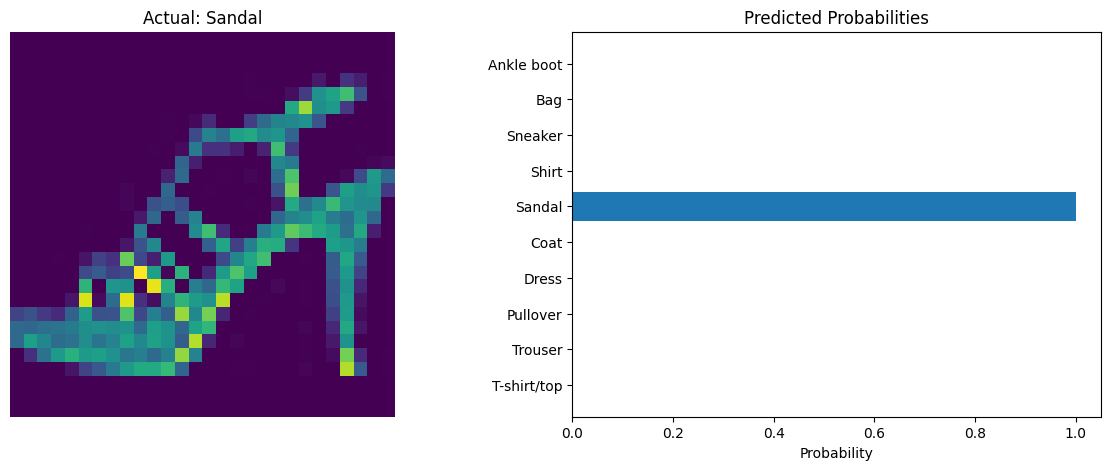

In [61]:
random_view(Fash_model)

In [62]:
# Saving model info
check_point = {'state_dict' : Fash_model.state_dict()}

In [63]:
# Saving the model
torch.save(check_point, 'Fash_model.pth')

In [64]:
# Model can be loaded using this function
def load_check_point(file):
    check_point = torch.load(file)
    Fash_model.load_state_dict(check_point['state_dict'])
    
    return Fash_model

In [65]:
# Loading the model
my_model = load_check_point('Fash_model.pth')

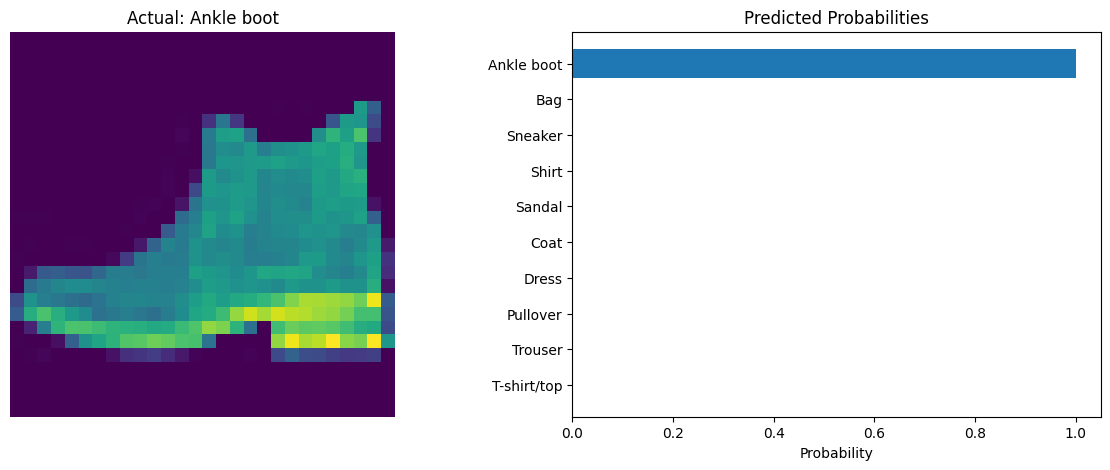

In [68]:
# Testing the Model
random_view(my_model)